In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow import keras
import warnings
import chardet
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
with open("C:\Datasets\spam.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.726526172671652, 'language': ''}


In [3]:
data = pd.read_csv('C:\Datasets\spam.csv',encoding='Windows-1252')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data = data[['v2','v1']]
data.rename(columns = {'v2': 'mails','v1':'label'},inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mails   5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
data['label'] = data['label'].map({'spam':1,'ham':0})

In [6]:
data.head()

,mails,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Text(0.5, 1.0, 'Ham or Spam')

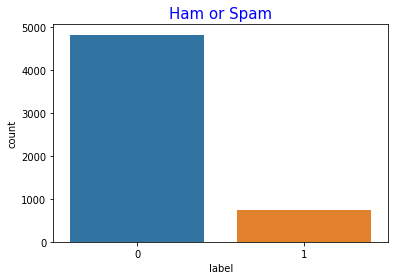

In [7]:
sns.countplot(data.label)
plt.title("Ham or Spam",color = 'blue',fontsize=15)

In [8]:
def show_wordcloud(df,title):
    words = ' '.join(df['mails'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()

In [9]:
data_spam = data[data['label'] == 1]
data_ham = data[data['label'] == 0]

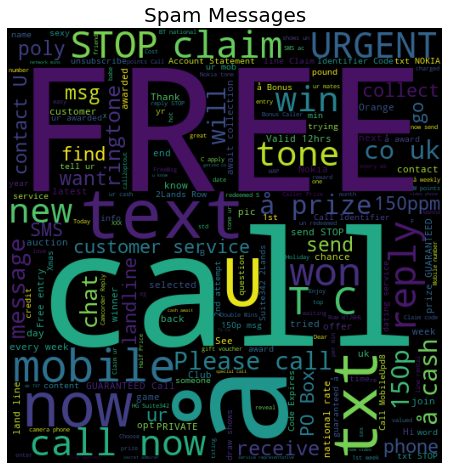

In [10]:
show_wordcloud(data_spam,'Spam Messages')

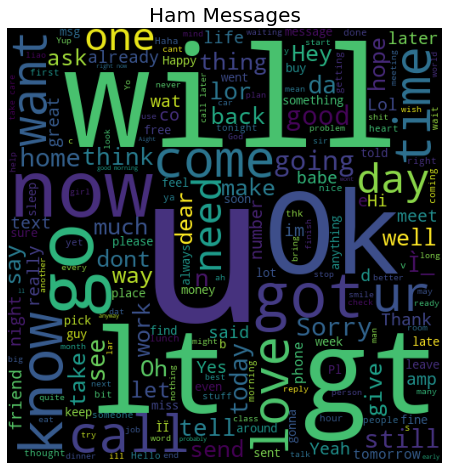

In [11]:
#we can see above that call,free,won,claim,cash,prize are in spam mails
#now we plot WordCloud of Non-spam mails
show_wordcloud(data_ham,'Ham Messages')

In [12]:
#text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

#layers, models, callbacks for modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping

#splitting dataset into train and test
from sklearn.model_selection import train_test_split

In [13]:
X = data['mails'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
t = Tokenizer()
t.fit_on_texts(X_train)
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [15]:
max_length = 10
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen = max_length, padding='post')
print(padded_train)

[[  11 1656  322 ...   30  349 1990]
 [1657 2557 1992 ...  203 1025  225]
 [ 113   83 1443 ... 3794 3795    0]
 ...
 [1477   30 2063 ... 2064    0    0]
 [ 763 1679 1161 ...    0    0    0]
 [   8  155   20 ...  175    0    0]]


In [16]:
vocab_size = len(t.word_index) + 1
def model_builder(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim = hp.Int('embedding_dim', min_value=16, max_value=40, step=8), input_length=max_length))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=100, max_value=500, step=25),activation='relu'))
    model.add(Dense(units=hp.Int('dense_2_units', min_value=100, max_value=300, step=50),activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=hp.Int('dense_3_units', min_value=50, max_value=200, step=50),activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
     
    model.compile(optimizer='adam',
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [17]:
import kerastuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=5,
                     directory='my_dir',
                     project_name='spam_or_ham_kt',
                     overwrite=True)

In [18]:
stop_early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
tuner.search(padded_train, y_train, epochs=15, validation_data=(padded_test,y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 18s]
val_accuracy: 0.9793722033500671

Best val_accuracy So Far: 0.9829596281051636
Total elapsed time: 00h 02m 17s
INFO:tensorflow:Oracle triggered exit


In [19]:
#building model with best_hps
model = tuner.hypermodel.build(best_hps)
history = model.fit(padded_train, y_train, epochs=50, validation_data=(padded_test,y_test),callbacks=[stop_early])

Epoch 1/50
140/140 [==============================] - 2s 10ms/step - loss: 0.3802 - accuracy: 0.8682 - val_loss: 0.1146 - val_accuracy: 0.9776
Epoch 2/50
140/140 [==============================] - 1s 9ms/step - loss: 0.0480 - accuracy: 0.9890 - val_loss: 0.0930 - val_accuracy: 0.9740
Epoch 3/50
140/140 [==============================] - 1s 9ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.1064 - val_accuracy: 0.9776
Epoch 4/50
140/140 [==============================] - 1s 9ms/step - loss: 5.4725e-04 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 0.9776
Epoch 5/50
140/140 [==============================] - 1s 9ms/step - loss: 3.1840e-04 - accuracy: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9776
Epoch 6/50
140/140 [==============================] - 1s 9ms/step - loss: 9.6005e-05 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.9776
Epoch 7/50
140/140 [==============================] - 1s 9ms/step - loss: 7.4013e-05 - accuracy: 1.0000 - val_loss: 0.1485 - val_accura

In [20]:
#we use the same model val_accuracy is constant 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 24)            190920    
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 425)               102425    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               42600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def c_report(y_true,y_pred):
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_scr))
    return acc_scr

def plot_cm(y_true,y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap="Blues", cbar = False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [22]:
preds = (model.predict(padded_test) > 0.5).astype("int32")
c_report(y_test,preds)

Classifictaion Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.95      0.88      0.91       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9775784753363229


0.9775784753363229

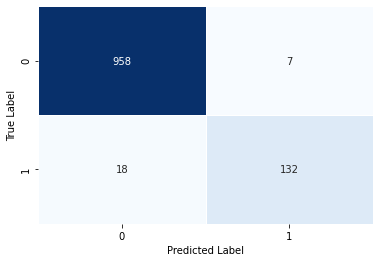

In [23]:
plot_cm(y_test,preds)

In [24]:
model.save('spam_model')
with open('spam_model/tokenizer.pkl','wb') as output:
    pickle.dump(t,output,pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: spam_model\assets


In [26]:
s_model = tf.keras.models.load_model('spam_model')
with open('spam_model/tokenizer.pkl','rb') as input:
    tokenizer = pickle.load(input)

In [30]:
sms = ["We know someone who you know that fancies you. Call 0918293453 to find out who. POBox 6, LS15HB"]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
def pred_print(pred):
    if pred == 1:
        print("Its a Spam!!")
    elif pred == 0:
        print("Its not a Spam!!")

pred_print(pred)

Its a Spam!!
